In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as op
import re
import pandas as pd

%matplotlib inline

/Users/greg/code/gkiar/clowdr-paper/env/cpaper/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load data

In this case, with the BIDS example, the following has been run:

```
git clone https://github.com/clowdr/clowdr ~/code/gkiar/clowdr
```

In [2]:
summary_dir = '/Users/greg/code/gkiar/clowdr/examples/task/bids-example/clowdr/'
summary_files = os.listdir(summary_dir)

In [3]:
cpu_r = re.compile('^task-([0-9]+)-cputiming.csv$')
cpu_files = {cpu_r.match(f).group(1): op.join(summary_dir, f)
             for f in summary_files
             if cpu_r.match(f) is not None}

mem_r = re.compile('^task-([0-9]+)-memory.csv$')
mem_files = {mem_r.match(f).group(1): op.join(summary_dir, f)
             for f in summary_files
             if mem_r.match(f) is not None}

### Visualize 1 execution

In [4]:
example_cpu = cpu_files['0']
example_cpu_data = pd.read_csv(example_cpu)
cpu_time = example_cpu_data.cumulativetime

sync_time = [p.cumulativetime
             for loc, p in example_cpu_data.iterrows()
             if "memory_profiler" in p.process
             if "__init__" in p.process]

example_mem = mem_files['0']
example_mem_data = pd.read_csv(example_mem)
mem_time = example_mem_data.systemtime - example_mem_data.systemtime[0] + sync_time
example_mem_data.systemtime = mem_time

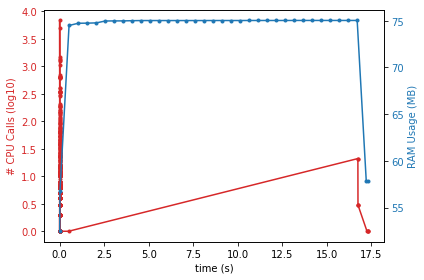

In [5]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('# CPU Calls (log10)', color=color)
ax1.plot(cpu_time, np.log10(example_cpu_data.ncall), color=color, marker='.')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RAM Usage (MB)', color=color)  # we already handled the x-label with ax1
ax2.plot(mem_time, example_mem_data['RAM (MB)'], color=color, marker='.')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Visualize Multiple Executions

In [6]:
tasks = cpu_files.keys()
nvals = 4

combined = pd.DataFrame(columns=['task', 'field', 'value'])
for tid, task in enumerate(tasks):
    ex_cpu = cpu_files[task]
    ex_cpu_data = pd.read_csv(ex_cpu)
    cpu_time = ex_cpu_data.cumulativetime

    sync_time = [p.cumulativetime
                 for loc, p in ex_cpu_data.iterrows()
                 if "memory_profiler" in p.process
                 if "__init__" in p.process]

    ex_mem = mem_files[task]
    ex_mem_data = pd.read_csv(ex_mem)
    mem_time = ex_mem_data.systemtime - ex_mem_data.systemtime[0] + sync_time
    ex_mem_data.systemtime = mem_time
    
    task=int(task)
    baseid = nvals*tid
    combined.loc[baseid] =   [task, 'cputiming', np.asarray(ex_cpu_data.cumulativetime)]
    combined.loc[baseid+1] = [task, 'cpu',       np.asarray(ex_cpu_data.ncall)]
    combined.loc[baseid+2] = [task, 'memtiming', np.asarray(ex_mem_data.systemtime)]
    combined.loc[baseid+3] = [task, 'mem',       np.asarray(ex_mem_data['RAM (MB)'])]

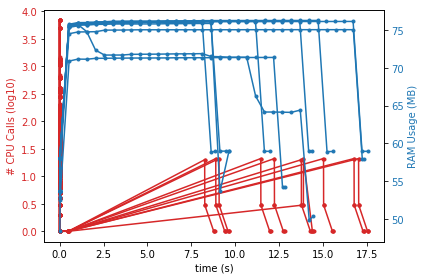

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for task in tasks:
    taskdat = combined.loc[combined['task'] == int(task)]

    tid = taskdat[taskdat.field == 'cputiming'].index.tolist()[0]
    t_cpu = taskdat.loc[taskdat.field == 'cputiming'].value[tid]
    y_cpu = taskdat.loc[taskdat.field == 'cpu'].value[tid+1]
    
    t_mem = taskdat.loc[taskdat.field == 'memtiming'].value[tid+2]
    y_mem = taskdat.loc[taskdat.field == 'mem'].value[tid+3]

    color = 'tab:red'
    ax1.plot(t_cpu, np.log10(y_cpu), color=color, marker='.')

    color = 'tab:blue'
    ax2.plot(t_mem, y_mem, color=color, marker='.',)
    
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('# CPU Calls (log10)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('RAM Usage (MB)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()